# Building circuits with `pytket`

## Creating a Circuit

To rewrite this wavefunction in terms of a circuit, i.e. taking a qubit initialized in the “ground state” and then applying the Hadamard gate, we need to first import the [circuit class](https://cqcl.github.io/pytket/manual/manual_circuit.html) from TKET.

In [3]:
from pytket import Circuit

Then to display the circuit we want to evaluate we also need to import

In [6]:
from pytket.circuit.display import render_circuit_jupyter

Then we define our circuit with a single qubit, q[0], and classical bit, c[0], and then apply the The Hadamard gate to it.

In [5]:
circ = Circuit(1,1)
circ.H(0)

[H q[0]; ]

At this step, the qubit q[0] is in a superposition state. We can show a schematic of the corresponding circuit by evaluating

In [6]:
render_circuit_jupyter(circ)

But a real device won't work like this. We cannot observe a full quantum state. We have to make observations and measurments. In fact, we need to sample from a probabilisitic distribution.

## Measurement

In `pytket`, all measurements are single-qubit measurements in the $\mathsf{Z}$-basis. Other forms of measurements can be constructed by combining these with other operations. Measurements produce classical data from the resulting state. Here, c[0] is a calssical register, or classical bit, which we obtain after measuring qubit q[0]. c[0] will either be 0 or 1.

In [7]:
circ.measure_all()
render_circuit_jupyter(circ)

Specifically, if we would prepare q[0] this way 1000 times and measure q[0], roughly 50% of the 1000 measures provided a 0 and 50% provided a 1, as expected.

To implement such measurements, we already installed `pytket-qiskit`. `pytket-qiskit` integrates `qiskit` into `pytket`, an IBM tool that, among other things, provides access to their quantum computers and numerous simulators. For this section, we will use the noiseless AerSimulator. This is a simulator we can run on our computer. We will discuss how to run a circuit on a "real" quantum computer in a different section.

In [8]:
from pytket.extensions.qiskit import AerBackend
backend = AerBackend()

We can check the required conditions to be satisfied for the circuit to be run on this backend. For this, we can use `required_predicates`. This tells us which gates are supported; in case gates are not supported, your circuit can be compiled for a given backend, and re-written in the supported gates, i.e. rotations can be decomposed into a set of Euler angles.

In [9]:
backend.required_predicates

[NoSymbolsPredicate,
 GateSetPredicate:{ S Barrier Sdg RangePredicate Unitary2qBox Z X Y T Tdg SX SXdg H Rx Ry Rz U3 U2 U1 TK1 CX CY CZ CU1 CU3 CCX SWAP CSWAP noop Measure Reset PhasedX XXPhase YYPhase ZZPhase CnX Unitary1qBox }]

Looks all good. the AerBackend supports the `H` gate and has a measurment option.

Next we run the circuits by sampling it. Since we have to sample, we have to indicate how many samples we want to take. Suppose we would like to get 10 shots out from the AerBackend (10 repeats of the circuit and measurement). We can seed the simulator's random-number generator to make the results reproducible, using an optional keyword argument to `process_circuit`.

In [10]:
handle = backend.process_circuit(circ, n_shots=10, seed=1)

Now, we can output a shot table:

In [11]:
shots = backend.get_result(handle).get_shots()
print(shots)

[[1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]


These are our 10 measurements. The column represents the classical register, c[0], of qubit q[0]. We can also get a summary of the results by looking at counts.

In [12]:
counts = backend.get_result(handle).get_counts()
print(counts)

Counter({(0,): 7, (1,): 3})


Or we can plot a histogram of our results.

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_counts(counts):
    counts_record = [{"State":state, "Count":count} for state, count in counts.items()]
    count_df = pd.DataFrame().from_records(counts_record)
    sns.catplot(x='State', y='Count', kind='bar', data=count_df, aspect = 3, height=2)
    plt.show()

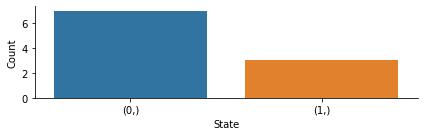

In [14]:
plot_counts(counts)

## Creating more complex circuits

We can make circuits more complicated than the example of the uniform superposition state above. Besides the Hadamard gate, among the most common gates are the rotations (around the X, Y, or Z axis) as well as the "control-NOT" (CNot), the controlled negation, also called `CX`. The list of all the gates available in `pytket` is quite long. It is
available in the documentation [here](https://cqcl.github.io/tket/pytket/api/optype.html).

Let's apply some of these gates to a new circuit with 3 qubits and 3 classical bits.

In [15]:
n_qubits = 3
n_bits = 3
circ2 = Circuit(n_qubits,n_bits)
# a X rotation with angle pi/2 on the qubit 1
circ2.Rx(0.5, 1)
# a Z rotation with angle pi/4 on the qubit 0
circ2.Rz(0.25, 0)
# a CNot gate between qubits 0 and 2
circ2.CX(0, 2)
circ2.measure_all()
render_circuit_jupyter(circ2)


We have seen how to define a circuit and visualize it, as well as how to run it on a simulator. Next, we will discuss how to run a circuit on an emulator or actual quantum computer.

## Convert between Qiskit and `pytket` circuits

For example, installing the `pytket-qiskit` package will add the `tk_to_qiskit` and `qiskit_to_tk` methods which convert between the Circuit class from `pytket` and `qiskit.QuantumCircuit`.

First write create circuit using Qiskit:

In [14]:
from qiskit import QuantumCircuit
from math import pi
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.rz(pi/2, 1)

print(qc)

     ┌───┐                
q_0: ┤ H ├──■─────────────
     └───┘┌─┴─┐┌─────────┐
q_1: ─────┤ X ├┤ Rz(π/2) ├
          └───┘└─────────┘
q_2: ─────────────────────
                          


Then we convert the circuit to `pytket`:

In [15]:
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit
circ = qiskit_to_tk(qc)
circ.CX(1, 2)
render_circuit_jupyter(circ)

Finally, we can convert the `pytket` circuit back to a Qiskit circuit:

In [16]:
qc2 = tk_to_qiskit(circ)
print(qc2)

     ┌───┐                     
q_0: ┤ H ├──■──────────────────
     └───┘┌─┴─┐┌─────────┐     
q_1: ─────┤ X ├┤ Rz(π/2) ├──■──
          └───┘└─────────┘┌─┴─┐
q_2: ─────────────────────┤ X ├
                          └───┘
